# Aprendizaje automático y aplicaciones

## Clasificación de imágenes con redes neuronales (caso de estudio)

---
$A^3$ @ FI-UNER : 2021

En esta última notebook veremos un ejemplo de cómo podemos incorporar modelos más complejos a nuestro pipeline. Esto es especialmente útil para hacer uso rápidamente de publicaciones recientes. 


In [1]:
# Imports básicos
from matplotlib import pyplot as plt
import numpy as np
import torch as tr
import pandas as pd 
import seaborn as sns 

## Dataset

In [3]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder


batch_size = 32
img_size = 224

train_transforms = transforms.Compose([transforms.Resize((img_size, img_size)),
                                       # Rotaciones y escalados aleatorios
                                       transforms.RandomAffine(degrees=20, 
                                                               scale=(0.5, 1.2), 
                                                               translate=(.2, .2), 
                                                               fill=255),  
                                       transforms.ToTensor()]) 

train_data = ImageFolder("train_dataset/", transform=train_transforms)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

# Para validación/test, usamos solo las transformaciones necesarias para 
# llevar los datos a la misma escala 
test_transforms = transforms.Compose([transforms.Resize((img_size, img_size)),
                                      transforms.ToTensor()]) 

valid_data = ImageFolder("valid_dataset/", transform=test_transforms)
valid_loader = DataLoader(valid_data, batch_size=batch_size)

test_data = ImageFolder("test_dataset/", transform=test_transforms)
test_loader = DataLoader(valid_data, batch_size=batch_size)


## Definición de la arquitectura

Para este problema vamos a usar una red convolucional de 2 dimensiones. La siguiente clase contine la red en si misma, el optimizador, la función de costo y las funciones auxiliares para entrenar y evaluar el modelo

Se pueden ver modelos recientes para imágenes en 
https://pytorch.org/vision/stable/models.html. En este link encontrarán los artículos relacionados a cada modelo junto con la documentación del código.

Para cada modelo hay que verificar cuales son las salidas, para ajustar las etapas siguientes. 
En este caso, ResNet50 ya tiene una capa lineal al final, por lo que solo vamos a reemplazar 
esa por una acorde a nuestro problema

In [4]:
from torch import nn, optim
from sklearn.metrics import balanced_accuracy_score

from torchvision.models import resnet50

class CNN(nn.Module):
    '''
    ResNet50 con 10 clases de salida.    
    '''
    
    def __init__(self, input_size, i_channels, n_outputs, device):
        
        super(CNN, self).__init__()
        
        # En lugar de nuestra CNN, vamos a usar una resnet
        self.net = resnet50()
        self.net.fc = nn.Linear(2048, n_outputs)
        
        self.loss_criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.parameters(), lr=1e-3)
        
        self.to(device)
        self.device = device

    def forward(self, x):
        
        y = self.net(x) # etapa convolucional
    
        return y  
    
    def train_step(self, dataloader):
        self.train()  
        cummulated_loss = 0
    
        for X, y in dataloader:

            self.optimizer.zero_grad()  
            y_pred = self(X.to(self.device))
            
            loss = self.loss_criterion(y_pred, y.to(self.device))
        
            cummulated_loss += loss.item() / len(dataloader)
        
            loss.backward()
            self.optimizer.step()
        
        return cummulated_loss
    
    
    def valid_step(self, dataloader):
        self.eval()  
        cummulated_loss = 0
        
        y_all, y_pred_all = [], []
        
        for X, y in dataloader:
          
            y_pred = self(X.to(self.device))
            
            # Acumulamos predicciones y etiquetas para calcular accuracy al final
            y_pred_all.append(tr.argmax(y_pred, axis=1).cpu().detach())
            y_all.append(y.cpu())
            
            loss = self.loss_criterion(y_pred, y.to(self.device))
        
            cummulated_loss += loss.item() / len(dataloader)
            
        
        bal_acc = balanced_accuracy_score(tr.cat(y_all), tr.cat(y_pred_all))
        return cummulated_loss, bal_acc


img_size = 250
net = CNN(img_size, 1, 10, device="cuda")
net

CNN(
  (net): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Con

In [4]:
MAX_EPOCHS = 200
best_loss = 9999
model = CNN(img_size, 1, 10, device="cuda")

epoch = 0
counter = 0

log = {"train_loss": [], "valid_loss": [], "valid_bal_acc": []}

while (epoch < MAX_EPOCHS) and (counter < 20):
    
    #------------
    # TRAIN
    #------------
    train_loss = model.train_step(train_loader)
    valid_loss, valid_bal_acc = model.valid_step(valid_loader)
    
    log["train_loss"].append(train_loss)
    log["valid_loss"].append(valid_loss)
    log["valid_bal_acc"].append(valid_bal_acc)
    
    #=================================
    if (valid_loss < best_loss):
        
        # Actualizo best_loss
        best_loss = valid_loss
        best_epoch = epoch
        
        # Guardo mejor modelo
        best_model = model.state_dict()
        counter = 0
    else:
        counter += 1
    #=================================

    if epoch % 10 == 0:
        print(f"Epoch {epoch: 03d}: train loss {train_loss: .2f} | valid loss {valid_loss: .2f} | valid balanced accuracy {valid_bal_acc: .2f}")
    epoch += 1

tr.save(best_model, 'cnn2d_resnet50.pmt')

/home/leandro/.local/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch  00: train loss  2.04 | valid loss  2.05 | valid balanced accuracy  0.29
Epoch  10: train loss  0.87 | valid loss  3.06 | valid balanced accuracy  0.43
Epoch  20: train loss  0.67 | valid loss  0.82 | valid balanced accuracy  0.81
Epoch  30: train loss  0.52 | valid loss  0.26 | valid balanced accuracy  0.94
Epoch  40: train loss  0.49 | valid loss  0.50 | valid balanced accuracy  0.83
Epoch  50: train loss  0.44 | valid loss  0.23 | valid balanced accuracy  0.94
Epoch  60: train loss  0.40 | valid loss  0.27 | valid balanced accuracy  0.93
Epoch  70: train loss  0.34 | valid loss  0.23 | valid balanced accuracy  0.93


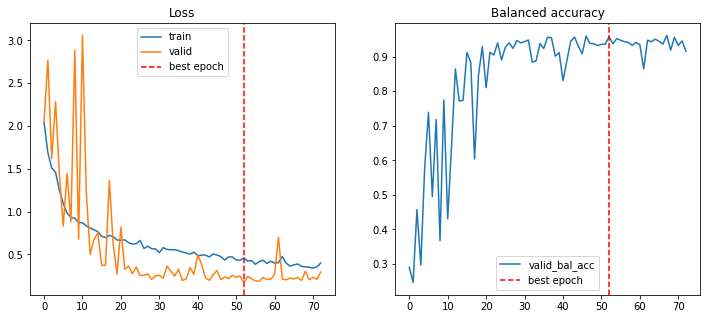

In [5]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(log["train_loss"], label="train")
plt.plot(log["valid_loss"], label="valid")
#plt.plot(best_epoch, [min(log["train_loss"]), max(log["train_loss"])])
plt.axvline(best_epoch, color="r", linestyle="--", label="best epoch")
plt.title("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(log["valid_bal_acc"], label="valid_bal_acc")
plt.axvline(best_epoch, color="r", linestyle="--", label="best epoch")
plt.legend()
plt.title("Balanced accuracy");


## Análisis de resultados

Vemos que la evaluación en train/validación parece razonable, ahora evaluamos en la partición de test

In [5]:
# Cargamos el mejor modelo
model = CNN(img_size, 1, 10, device="cpu")
model.load_state_dict(tr.load("cnn2d_resnet50.pmt"))

test_loss, test_bal_acc = model.valid_step(test_loader)
print(f"Test loss {test_loss: .3f}, Test balanced accuracy {test_bal_acc: .3f}")

/home/leandro/.local/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Test loss  0.294, Test balanced accuracy  0.915


En clasificación, la matriz de confusión nos da una mejor idea de que esta pasando

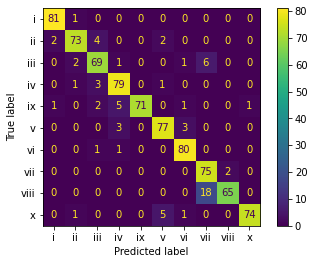

In [7]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

model.eval()
pred, labels = [], []
for img, label in test_loader:
    out = model(img).detach().cpu()
    
    labels.append(label)
    pred.append(tr.argmax(out, axis=1))
    
labels = tr.cat(labels)
pred = tr.cat(pred)
confm = confusion_matrix(labels, pred)
ConfusionMatrixDisplay(confm, display_labels=train_data.classes).plot();

## Aprendizaje por transferencia 
En algunos casos tenemos que resolver una tarea general para la que ya existen modelos que funcionan bien. En estos casos podemos usar parte del modelo ya entrenado, donde se utilizó una gran cantidad de datos para ese fin, y solo cambiamos la parte final del modelo. Esto se conoce como aprendizaje por transferencia.

La justificación esta dada por la idea de que las primeras capas de la red obtendrán características generales de una imagen (por ejemplo sus bordes) mientras que las capas finales obtienen características más complejas acordes a la aplicación particular. 

No siempre es la mejor opción. En este caso da peores resultados porque las imágenes tienen una distribución bastante diferente a las de entrenamiento. También se puede implementar algo intermedio: "congelar" solo las primeras capas, que son las más generales, y luego entrenar el resto.  

In [8]:
from torch import nn, optim
from sklearn.metrics import balanced_accuracy_score

from torchvision.models import resnet50

class CNN(nn.Module):
    '''
    ResNet50 preentrenada con ImageNet, modificada para que tenga 10 clases de salida 
    '''
    
    def __init__(self, input_size, i_channels, n_outputs, device):
        
        super(CNN, self).__init__()
        
        # En lugar de nuestra CNN, vamos a usar una resnet. Con pretrained=True descarga pesos 
        # de una red entrenada sobre millones de imágenes a color de 1000 clases diferentes.
        self.net = resnet50(pretrained=True)
        
        # "Congelamos" los parámetros. Al indicar que no se requiere calcular gradientes,
        # estos parámetros se toman como constantes y no se modifican en el proceso de ajuste 
        # de la red
        for param in self.net.parameters():
            param.requires_grad = False 
          
        # Solo modificaremos estos, que por defecto tiene requires_grad = True
        self.net.fc = nn.Linear(2048, n_outputs)
        
        self.loss_criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.net.fc.parameters(), lr=1e-3) # solo se ajustan los pesos de la última capa
        
        self.to(device)
        self.device = device

    def forward(self, x):
        
        y = self.net(x) # etapa convolucional
    
        return y  
    
    def train_step(self, dataloader):
        self.train()  
        cummulated_loss = 0
    
        for X, y in dataloader:

            self.optimizer.zero_grad()  
            y_pred = self(X.to(self.device))
            
            loss = self.loss_criterion(y_pred, y.to(self.device))
        
            cummulated_loss += loss.item() / len(dataloader)
        
            loss.backward()
            self.optimizer.step()
        
        return cummulated_loss
    
    
    def valid_step(self, dataloader):
        self.eval()  
        cummulated_loss = 0
        
        y_all, y_pred_all = [], []
        
        for X, y in dataloader:
          
            y_pred = self(X.to(self.device))
            
            # Acumulamos predicciones y etiquetas para calcular accuracy al final
            y_pred_all.append(tr.argmax(y_pred, axis=1).cpu().detach())
            y_all.append(y.cpu())
            
            loss = self.loss_criterion(y_pred, y.to(self.device))
        
            cummulated_loss += loss.item() / len(dataloader)
            
        
        bal_acc = balanced_accuracy_score(tr.cat(y_all), tr.cat(y_pred_all))
        return cummulated_loss, bal_acc


img_size = 250
net = CNN(img_size, 1, 10, device="cuda")